In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=40, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=40, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


#Task 1
#VGG 

In [3]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# Freeze training for all layers
for param in vgg16.parameters():
    param.require_grad = False

num_features = vgg16.classifier[0].in_features
#classifiers = list(vgg16.classifier.children())[:-1]
classifiers=[]
classifiers.extend([nn.Linear(num_features, 240)])
classifiers.extend([nn.ReLU(inplace=True)])
classifiers.extend([nn.Dropout(p=0.5, inplace=False)])
classifiers.extend([nn.Linear(240, 2)])
vgg16.classifier = nn.Sequential(*classifiers)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg16.to(device)
vgg16.train()

predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

train_losses,train_accuracies,val_losses,val_accuracies=[],[],[],[]
confusion_matrices_val,confusion_matrices_train=[],[]
best_accuracy=0
for epoch in range(Epochs):  # loop over the dataset multiple times
  print('Epoch',epoch)
  for mode in ['train', 'validation']:
    running_loss = 0.0
    correct_predictions = 0
    if mode=='train':
      pbar = enumerate(trainloader)
    else:
      pbar = enumerate(valloader)
    running_loss = 0.0
    correct_predictions = 0

    for i, data in pbar:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = vgg16(inputs)            #----> forward pass
      _, predicted = torch.max(outputs, 1)
      loss = criterion(outputs, labels)   #----> compute loss
      if mode=='train':
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      running_loss += loss.item()
      correct_predictions += torch.sum(predicted == labels.data)

      predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
      labelsList = torch.cat([labelsList,labels.view(-1).cpu()])
            
    epoch_accuracy = correct_predictions.double() /1090
    epoch_loss = running_loss /1090
    print('Mode:',mode)
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                      epoch_loss, epoch_accuracy))
        
    cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
    # print('Confusion Matrix',cf_mat)
        
    if mode == 'validation':
      if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
      val_accuracies.append(epoch_accuracy)
      val_losses.append(epoch_loss)
      confusion_matrices_val.append(cf_mat)
    elif mode == 'train':
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_accuracy)
      confusion_matrices_train.append(cf_mat)
      
  torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')
print('Finished Training')

Epoch 0
Mode: train
Loss: 0.0146 Acc: 0.6890
Mode: validation
Loss: 0.0151 Acc: 0.7532
Epoch 1
Mode: train
Loss: 0.0104 Acc: 0.8358
Mode: validation
Loss: 0.0107 Acc: 0.8385
Epoch 2
Mode: train
Loss: 0.0087 Acc: 0.8651
Mode: validation
Loss: 0.0098 Acc: 0.8404
Epoch 3
Mode: train
Loss: 0.0085 Acc: 0.8560
Mode: validation
Loss: 0.0087 Acc: 0.8532
Epoch 4
Mode: train
Loss: 0.0078 Acc: 0.8716
Mode: validation
Loss: 0.0089 Acc: 0.8734
Epoch 5
Mode: train
Loss: 0.0082 Acc: 0.8752
Mode: validation
Loss: 0.0079 Acc: 0.8807
Epoch 6
Mode: train
Loss: 0.0075 Acc: 0.8945
Mode: validation
Loss: 0.0070 Acc: 0.8936
Epoch 7
Mode: train
Loss: 0.0070 Acc: 0.8890
Mode: validation
Loss: 0.0067 Acc: 0.8982
Epoch 8
Mode: train
Loss: 0.0070 Acc: 0.8881
Mode: validation
Loss: 0.0067 Acc: 0.8954
Epoch 9
Mode: train
Loss: 0.0065 Acc: 0.9046
Mode: validation
Loss: 0.0103 Acc: 0.8202
Epoch 10
Mode: train
Loss: 0.0066 Acc: 0.8936
Mode: validation
Loss: 0.0071 Acc: 0.8927
Epoch 11
Mode: train
Loss: 0.0061 Acc: 0.9

Text(0.5, 1.0, 'Validation Data: Accuracy on each Epoch')

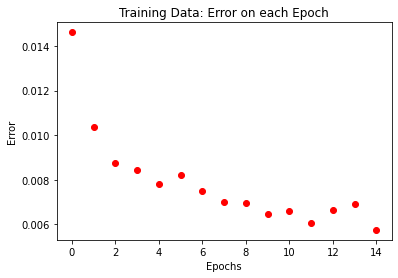

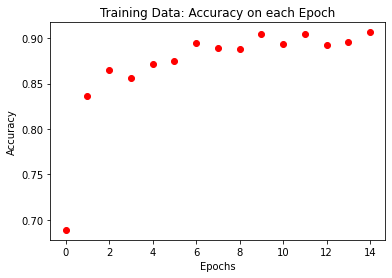

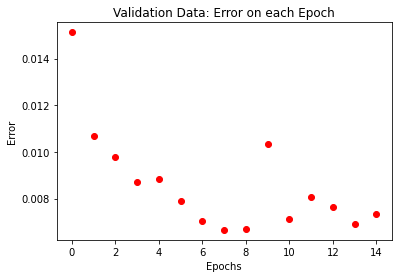

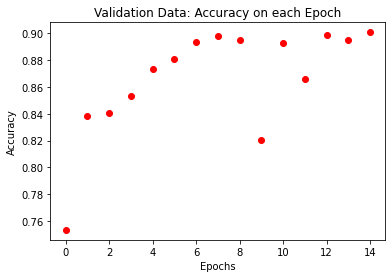

In [5]:
plt.figure()
plt.plot(train_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Data: Error on each Epoch')

plt.figure()
plt.plot(train_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Data: Accuracy on each Epoch')

plt.figure()
plt.plot(val_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Validation Data: Error on each Epoch')

plt.figure()
plt.plot(val_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Data: Accuracy on each Epoch')

In [6]:
print('Final Training Confusion Matrix')
print(confusion_matrices_train[-1])
print('Final Validation Confusion Matrix')
print(confusion_matrices_val[-1])

Final Training Confusion Matrix
[[12976  1584]
 [ 2684 14450]]
Final Validation Confusion Matrix
[[13561  1668]
 [ 2714 14847]]


In [7]:
cf=confusion_matrices_train[-1]
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy: 0.8653372878147283
F1 Score: 0.8587690271343481


Test Data

In [8]:
correct = 0
total = 0

predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
        labelsList = torch.cat([labelsList,labels.view(-1).cpu()])

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
print('Conusion Matrix',cf_mat)

Accuracy of the network on test images: 94 %
Conusion Matrix [[570  45]
 [ 22 583]]


In [68]:
correct = 0
total = 0
image11=0
image12=0
image13=0
image14=0
image21=0
image22=0
image23=0
image24=0
predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

with torch.no_grad():
    first_l1=True
    first_l2=True
    first_l3=True
    first_l4=True
    highest_prob=0
    lowest_prob=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
          if labels[i].item()==0:
            if predicted[i]==labels[i]:
              if first_l1:
                image11=images[i]
                image12=images[i]
                first_l1=False
              if torch.max(outputs[i].data)>highest_prob:
                image12=image11
                image11=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l2:
                imagel3=images[i]
                image14=images[i]
                first_l2=False
              if torch.min(outputs[i].data)<lowest_prob:
                image14=image13
                image13=images[i]
                lowest_prob=torch.min(outputs[i].data)
          elif labels[i].item()==1:
            if predicted[i]==labels[i]:
              if first_l3:
                image22=images[i]
                image21=images[i]
                first_l3=False
              if torch.max(outputs[i].data)>highest_prob:
                image22=image21
                image21=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l4:
                image23=images[i]
                image24=images[i]
                first_l4=False
              if torch.min(outputs[i].data)<lowest_prob:
                image24=image23
                image23=images[i]
                lowest_prob=torch.min(outputs[i].data)

        predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
        labelsList = torch.cat([labelsList,labels.view(-1).cpu()])

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
print('Conusion Matrix',cf_mat)


Accuracy of the network on test images: 94 %
Conusion Matrix [[570  45]
 [ 22 583]]


In [69]:
cf=cf_mat
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy: 0.9450819672131148
F1 Score: 0.9444904722452361


In [0]:
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    plt.title(title)
    plt.pause(0.001)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


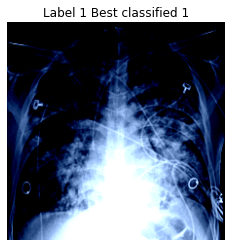

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


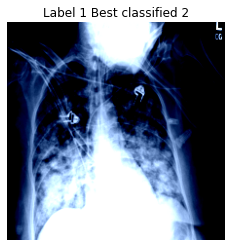

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


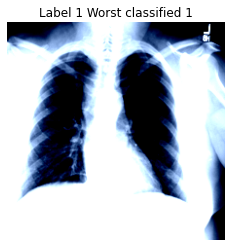

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


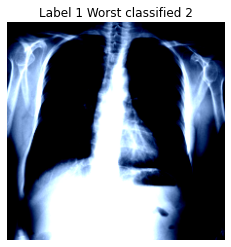

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


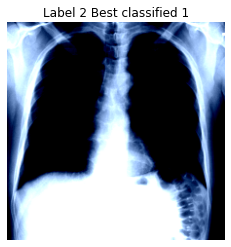

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


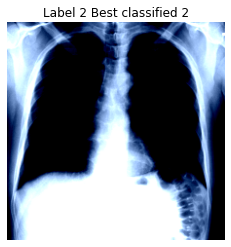

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


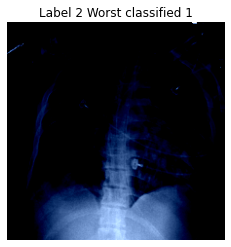

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


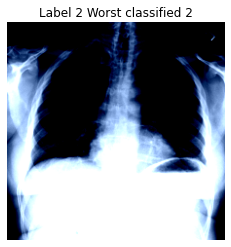

In [70]:

l=torchvision.utils.make_grid(image11)
imshow(l,'Label 1 Best classified 1')
l2=torchvision.utils.make_grid(image12)
imshow(l2,'Label 1 Best classified 2')

l3=torchvision.utils.make_grid(image13)
imshow(l3,'Label 1 Worst classified 1')
l4=torchvision.utils.make_grid(image14)
imshow(l4,'Label 1 Worst classified 2')

l=torchvision.utils.make_grid(image21)
imshow(l,'Label 2 Best classified 1')
l2=torchvision.utils.make_grid(image22)
imshow(l2,'Label 2 Best classified 2')

l3=torchvision.utils.make_grid(image23)
imshow(l3,'Label 2 Worst classified 1')
l4=torchvision.utils.make_grid(image24)
imshow(l4,'Label 2 Worst classified 2')

# RESNET18

In [9]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)

# Freeze training for all layers
for param in res18.parameters():
    param.require_grad = False

res18.fc = nn.Sequential(nn.Linear(512, 240),nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear(240, 2))
print(res18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [10]:
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

res18.to(device)
res18.train()

predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

train_losses,train_accuracies,val_losses,val_accuracies=[],[],[],[]
confusion_matrices_val,confusion_matrices_train=[],[]
best_accuracy=0
for epoch in range(Epochs):  # loop over the dataset multiple times
  print('Epoch',epoch)
  for mode in ['train', 'validation']:
    running_loss = 0.0
    correct_predictions = 0
    if mode=='train':
      pbar = enumerate(trainloader)
    else:
      pbar = enumerate(valloader)
    running_loss = 0.0
    correct_predictions = 0

    for i, data in pbar:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = res18(inputs)            #----> forward pass
      _, predicted = torch.max(outputs, 1)
      loss = criterion(outputs, labels)   #----> compute loss
      if mode=='train':
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      running_loss += loss.item()
      correct_predictions += torch.sum(predicted == labels.data)

      predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
      labelsList = torch.cat([labelsList,labels.view(-1).cpu()])
            
    epoch_accuracy = correct_predictions.double() /1090
    epoch_loss = running_loss /1090
    print('Mode:',mode)
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                      epoch_loss, epoch_accuracy))
        
    cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
    # print('Confusion Matrix',cf_mat)
        
    if mode == 'validation':
      if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
      val_accuracies.append(epoch_accuracy)
      val_losses.append(epoch_loss)
      confusion_matrices_val.append(cf_mat)
    elif mode == 'train':
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_accuracy)
      confusion_matrices_train.append(cf_mat)
      
  torch.save(res18.state_dict(), 'res18_FC_Only.pth')
print('Finished Training')

Epoch 0
Mode: train
Loss: 0.0168 Acc: 0.6147
Mode: validation
Loss: 0.0151 Acc: 0.7147
Epoch 1
Mode: train
Loss: 0.0132 Acc: 0.7633
Mode: validation
Loss: 0.0128 Acc: 0.7789
Epoch 2
Mode: train
Loss: 0.0112 Acc: 0.8128
Mode: validation
Loss: 0.0113 Acc: 0.8138
Epoch 3
Mode: train
Loss: 0.0100 Acc: 0.8312
Mode: validation
Loss: 0.0126 Acc: 0.7826
Epoch 4
Mode: train
Loss: 0.0092 Acc: 0.8394
Mode: validation
Loss: 0.0125 Acc: 0.7972
Epoch 5
Mode: train
Loss: 0.0089 Acc: 0.8532
Mode: validation
Loss: 0.0101 Acc: 0.8440
Epoch 6
Mode: train
Loss: 0.0098 Acc: 0.8468
Mode: validation
Loss: 0.0088 Acc: 0.8624
Epoch 7
Mode: train
Loss: 0.0083 Acc: 0.8734
Mode: validation
Loss: 0.0103 Acc: 0.8431
Epoch 8
Mode: train
Loss: 0.0078 Acc: 0.8752
Mode: validation
Loss: 0.0103 Acc: 0.8440
Epoch 9
Mode: train
Loss: 0.0078 Acc: 0.8734
Mode: validation
Loss: 0.0096 Acc: 0.8486
Epoch 10
Mode: train
Loss: 0.0072 Acc: 0.8826
Mode: validation
Loss: 0.0089 Acc: 0.8633
Epoch 11
Mode: train
Loss: 0.0067 Acc: 0.8

Text(0.5, 1.0, 'Validation Data: Accuracy on each Epoch')

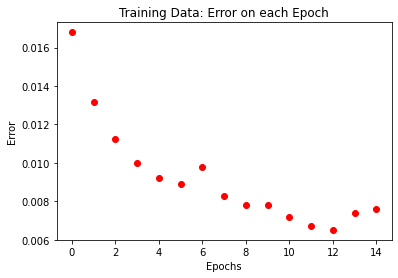

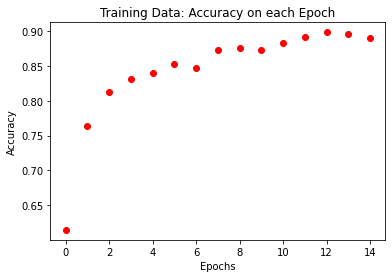

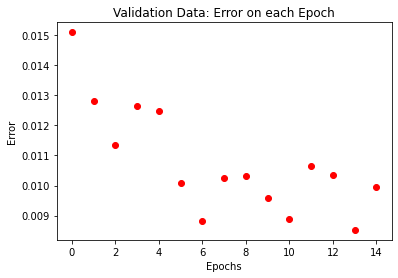

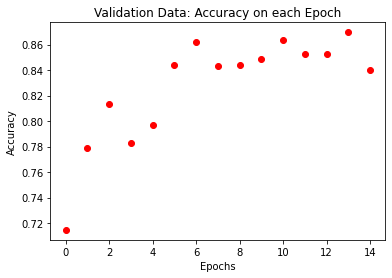

In [11]:
plt.figure()
plt.plot(train_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Data: Error on each Epoch')

plt.figure()
plt.plot(train_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Data: Accuracy on each Epoch')

plt.figure()
plt.plot(val_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Validation Data: Error on each Epoch')

plt.figure()
plt.plot(val_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Data: Accuracy on each Epoch')

In [43]:
print('Final Training Confusion Matrix')
print(confusion_matrices_train[-1])
print('Final Validation Confusion Matrix')
print(confusion_matrices_val[-1])

Final Training Confusion Matrix
[[12134  1781]
 [ 3526 14253]]
Final Validation Confusion Matrix
[[12593  1805]
 [ 3682 14710]]


In [71]:
cf=[[12134,1781],[ 3526, 14253]]
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy: 0.8325550577396352
F1 Score: 0.8205579036348267


In [72]:
correct = 0
total = 0
image11=0
image12=0
image13=0
image14=0
image21=0
image22=0
image23=0
image24=0
predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

with torch.no_grad():
    first_l1=True
    first_l2=True
    first_l3=True
    first_l4=True
    highest_prob=0
    lowest_prob=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
          if labels[i].item()==0:
            if predicted[i]==labels[i]:
              if first_l1:
                image11=images[i]
                image12=images[i]
                first_l1=False
              if torch.max(outputs[i].data)>highest_prob:
                image12=image11
                image11=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l2:
                imagel3=images[i]
                image14=images[i]
                first_l2=False
              if torch.min(outputs[i].data)<lowest_prob:
                image14=image13
                image13=images[i]
                lowest_prob=torch.min(outputs[i].data)
          elif labels[i].item()==1:
            if predicted[i]==labels[i]:
              if first_l3:
                image22=images[i]
                image21=images[i]
                first_l3=False
              if torch.max(outputs[i].data)>highest_prob:
                image22=image21
                image21=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l4:
                image23=images[i]
                image24=images[i]
                first_l4=False
              if torch.min(outputs[i].data)<lowest_prob:
                image24=image23
                image23=images[i]
                lowest_prob=torch.min(outputs[i].data)

        predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
        labelsList = torch.cat([labelsList,labels.view(-1).cpu()])

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
print('Conusion Matrix',cf_mat)


Accuracy of the network on test images: 93 %
Conusion Matrix [[524   9]
 [ 68 619]]


In [73]:
cf=cf_mat
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy: 0.9368852459016394
F1 Score: 0.9315555555555555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


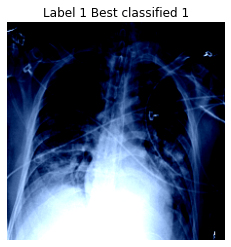

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


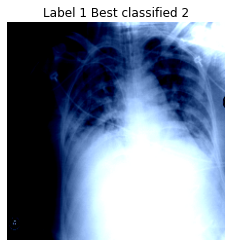

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


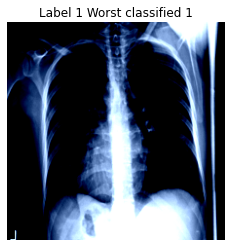

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


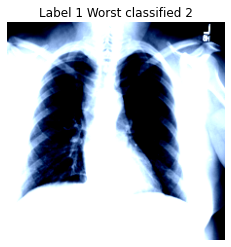

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


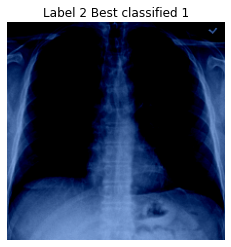

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


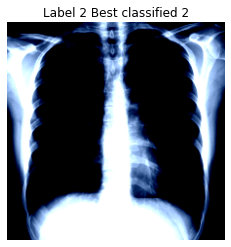

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


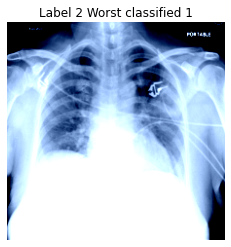

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


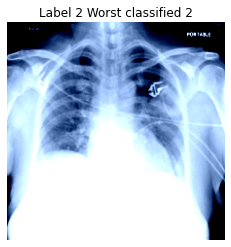

In [74]:
l=torchvision.utils.make_grid(image11)
imshow(l,'Label 1 Best classified 1')
l2=torchvision.utils.make_grid(image12)
imshow(l2,'Label 1 Best classified 2')

l3=torchvision.utils.make_grid(image13)
imshow(l3,'Label 1 Worst classified 1')
l4=torchvision.utils.make_grid(image14)
imshow(l4,'Label 1 Worst classified 2')

l=torchvision.utils.make_grid(image21)
imshow(l,'Label 2 Best classified 1')
l2=torchvision.utils.make_grid(image22)
imshow(l2,'Label 2 Best classified 2')

l3=torchvision.utils.make_grid(image23)
imshow(l3,'Label 2 Worst classified 1')
l4=torchvision.utils.make_grid(image24)
imshow(l4,'Label 2 Worst classified 2')

#Task 2
#VGG

Unfreezed Convultion Layers

In [75]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

classifiers=[]
classifiers.extend([nn.Linear(num_features, 240)])
classifiers.extend([nn.ReLU(inplace=True)])
classifiers.extend([nn.Dropout(p=0.5, inplace=False)])
classifiers.extend([nn.Linear(240, 2)])
vgg16.classifier = nn.Sequential(*classifiers)
print(vgg16)

# Freeze training for all layers except conv layers
for param in vgg16.classifier.parameters():
    param.require_grad = False

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [76]:
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg16.to(device)
vgg16.train()

predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

train_losses,train_accuracies,val_losses,val_accuracies=[],[],[],[]
confusion_matrices_val,confusion_matrices_train=[],[]
best_accuracy=0
for epoch in range(Epochs):  # loop over the dataset multiple times
  print('Epoch',epoch)
  for mode in ['train', 'validation']:
    running_loss = 0.0
    correct_predictions = 0
    if mode=='train':
      pbar = enumerate(trainloader)
    else:
      pbar = enumerate(valloader)
    running_loss = 0.0
    correct_predictions = 0

    for i, data in pbar:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = vgg16(inputs)            #----> forward pass
      _, predicted = torch.max(outputs, 1)
      loss = criterion(outputs, labels)   #----> compute loss
      if mode=='train':
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      running_loss += loss.item()
      correct_predictions += torch.sum(predicted == labels.data)

      predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
      labelsList = torch.cat([labelsList,labels.view(-1).cpu()])
            
    epoch_accuracy = correct_predictions.double() /1090
    epoch_loss = running_loss /1090
    print('Mode:',mode)
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                      epoch_loss, epoch_accuracy))
        
    cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
    # print('Confusion Matrix',cf_mat)
        
    if mode == 'validation':
      if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
      val_accuracies.append(epoch_accuracy)
      val_losses.append(epoch_loss)
      confusion_matrices_val.append(cf_mat)
    elif mode == 'train':
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_accuracy)
      confusion_matrices_train.append(cf_mat)
       
  torch.save(vgg16.state_dict(), 'vgg16_task2_conv_unfreeze.pth')
print('Finished Training')

Epoch 0
Mode: train
Loss: 0.0151 Acc: 0.6798
Mode: validation
Loss: 0.0155 Acc: 0.7385
Epoch 1
Mode: train
Loss: 0.0107 Acc: 0.8092
Mode: validation
Loss: 0.0110 Acc: 0.8174
Epoch 2
Mode: train
Loss: 0.0097 Acc: 0.8339
Mode: validation
Loss: 0.0103 Acc: 0.8248
Epoch 3
Mode: train
Loss: 0.0098 Acc: 0.8477
Mode: validation
Loss: 0.0083 Acc: 0.8587
Epoch 4
Mode: train
Loss: 0.0093 Acc: 0.8541
Mode: validation
Loss: 0.0073 Acc: 0.8780
Epoch 5
Mode: train
Loss: 0.0077 Acc: 0.8725
Mode: validation
Loss: 0.0074 Acc: 0.8734
Epoch 6
Mode: train
Loss: 0.0076 Acc: 0.8835
Mode: validation
Loss: 0.0071 Acc: 0.8862
Epoch 7
Mode: train
Loss: 0.0077 Acc: 0.8716
Mode: validation
Loss: 0.0071 Acc: 0.8899
Epoch 8
Mode: train
Loss: 0.0072 Acc: 0.8853
Mode: validation
Loss: 0.0065 Acc: 0.8972
Epoch 9
Mode: train
Loss: 0.0068 Acc: 0.8899
Mode: validation
Loss: 0.0088 Acc: 0.8486
Epoch 10
Mode: train
Loss: 0.0065 Acc: 0.8945
Mode: validation
Loss: 0.0080 Acc: 0.8881
Epoch 11
Mode: train
Loss: 0.0064 Acc: 0.8

Text(0.5, 1.0, 'Validation Data: Accuracy on each Epoch')

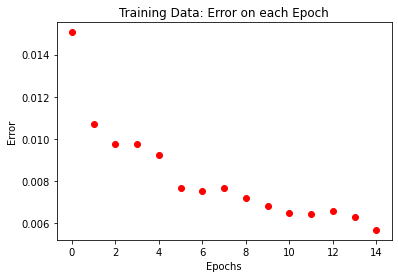

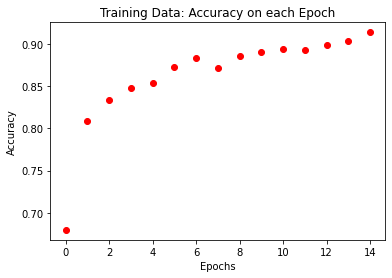

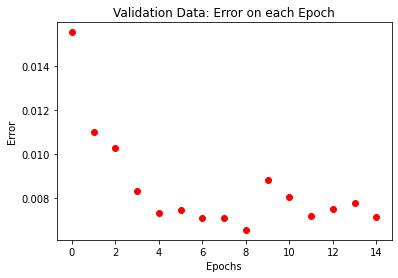

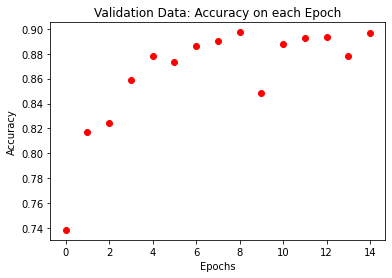

In [77]:
plt.figure()
plt.plot(train_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Data: Error on each Epoch')

plt.figure()
plt.plot(train_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Data: Accuracy on each Epoch')

plt.figure()
plt.plot(val_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Validation Data: Error on each Epoch')

plt.figure()
plt.plot(val_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Data: Accuracy on each Epoch')

In [78]:
print('Final Training Confusion Matrix')
print(confusion_matrices_train[-1])
print('Final Validation Confusion Matrix')
print(confusion_matrices_val[-1])

Final Training Confusion Matrix
[[12762  1551]
 [ 2898 14483]]
Final Validation Confusion Matrix
[[13315  1608]
 [ 2960 14907]]


In [79]:
cf=confusion_matrices_train[-1]
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy: 0.859626427715025
F1 Score: 0.851566409768792


In [80]:
correct = 0
total = 0
image11=0
image12=0
image13=0
image14=0
image21=0
image22=0
image23=0
image24=0
predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

with torch.no_grad():
    first_l1=True
    first_l2=True
    first_l3=True
    first_l4=True
    highest_prob=0
    lowest_prob=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
          if labels[i].item()==0:
            if predicted[i]==labels[i]:
              if first_l1:
                image11=images[i]
                image12=images[i]
                first_l1=False
              if torch.max(outputs[i].data)>highest_prob:
                image12=image11
                image11=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l2:
                imagel3=images[i]
                image14=images[i]
                first_l2=False
              if torch.min(outputs[i].data)<lowest_prob:
                image14=image13
                image13=images[i]
                lowest_prob=torch.min(outputs[i].data)
          elif labels[i].item()==1:
            if predicted[i]==labels[i]:
              if first_l3:
                image22=images[i]
                image21=images[i]
                first_l3=False
              if torch.max(outputs[i].data)>highest_prob:
                image22=image21
                image21=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l4:
                image23=images[i]
                image24=images[i]
                first_l4=False
              if torch.min(outputs[i].data)<lowest_prob:
                image24=image23
                image23=images[i]
                lowest_prob=torch.min(outputs[i].data)

        predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
        labelsList = torch.cat([labelsList,labels.view(-1).cpu()])

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
print('Conusion Matrix',cf_mat)

cf=cf_mat
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy of the network on test images: 95 %
Conusion Matrix [[562  19]
 [ 30 609]]
Accuracy: 0.9598360655737705
F1 Score: 0.958226768968457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


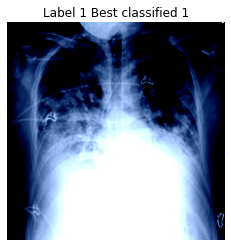

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


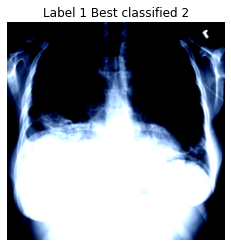

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


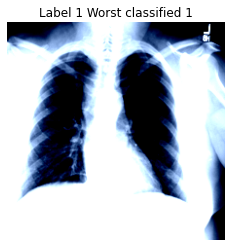

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


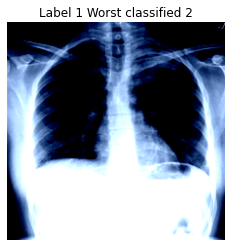

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


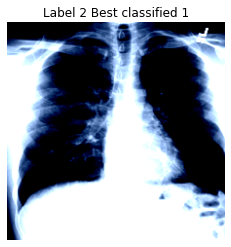

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


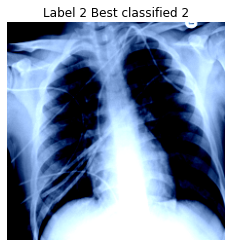

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


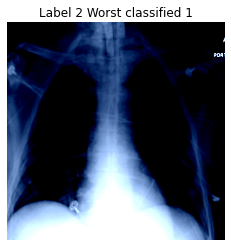

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


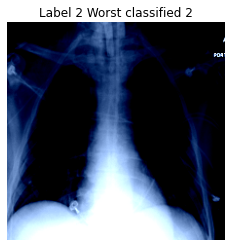

In [81]:
l=torchvision.utils.make_grid(image11)
imshow(l,'Label 1 Best classified 1')
l2=torchvision.utils.make_grid(image12)
imshow(l2,'Label 1 Best classified 2')

l3=torchvision.utils.make_grid(image13)
imshow(l3,'Label 1 Worst classified 1')
l4=torchvision.utils.make_grid(image14)
imshow(l4,'Label 1 Worst classified 2')

l=torchvision.utils.make_grid(image21)
imshow(l,'Label 2 Best classified 1')
l2=torchvision.utils.make_grid(image22)
imshow(l2,'Label 2 Best classified 2')

l3=torchvision.utils.make_grid(image23)
imshow(l3,'Label 2 Worst classified 1')
l4=torchvision.utils.make_grid(image24)
imshow(l4,'Label 2 Worst classified 2')

All VGG Unfreeze

In [82]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

classifiers=[]
classifiers.extend([nn.Linear(num_features, 240)])
classifiers.extend([nn.ReLU(inplace=True)])
classifiers.extend([nn.Dropout(p=0.5, inplace=False)])
classifiers.extend([nn.Linear(240, 2)])
vgg16.classifier = nn.Sequential(*classifiers)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [84]:
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg16.to(device)
vgg16.train()

predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

train_losses,train_accuracies,val_losses,val_accuracies=[],[],[],[]
confusion_matrices_val,confusion_matrices_train=[],[]
best_accuracy=0
for epoch in range(Epochs):  # loop over the dataset multiple times
  print('Epoch',epoch)
  for mode in ['train', 'validation']:
    running_loss = 0.0
    correct_predictions = 0
    if mode=='train':
      pbar = enumerate(trainloader)
    else:
      pbar = enumerate(valloader)
    running_loss = 0.0
    correct_predictions = 0

    for i, data in pbar:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = vgg16(inputs)            #----> forward pass
      _, predicted = torch.max(outputs, 1)
      loss = criterion(outputs, labels)   #----> compute loss
      if mode=='train':
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      running_loss += loss.item()
      correct_predictions += torch.sum(predicted == labels.data)

      predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
      labelsList = torch.cat([labelsList,labels.view(-1).cpu()])
            
    epoch_accuracy = correct_predictions.double() /1090
    epoch_loss = running_loss /1090
    print('Mode:',mode)
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                      epoch_loss, epoch_accuracy))
        
    cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
    # print('Confusion Matrix',cf_mat)
        
    if mode == 'validation':
      if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
      val_accuracies.append(epoch_accuracy)
      val_losses.append(epoch_loss)
      confusion_matrices_val.append(cf_mat)
    elif mode == 'train':
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_accuracy)
      confusion_matrices_train.append(cf_mat)
       
  torch.save(vgg16.state_dict(), 'vgg16_entire.pth')
print('Finished Training')

Epoch 0
Mode: train
Loss: 0.0108 Acc: 0.8440
Mode: validation
Loss: 0.0092 Acc: 0.8505
Epoch 1
Mode: train
Loss: 0.0114 Acc: 0.7899
Mode: validation
Loss: 0.0135 Acc: 0.7771
Epoch 2
Mode: train
Loss: 0.0093 Acc: 0.8303
Mode: validation
Loss: 0.0090 Acc: 0.8468
Epoch 3
Mode: train
Loss: 0.0078 Acc: 0.8853
Mode: validation
Loss: 0.0090 Acc: 0.8560
Epoch 4
Mode: train
Loss: 0.0078 Acc: 0.8826
Mode: validation
Loss: 0.0076 Acc: 0.8826
Epoch 5
Mode: train
Loss: 0.0079 Acc: 0.8761
Mode: validation
Loss: 0.0069 Acc: 0.8954
Epoch 6
Mode: train
Loss: 0.0068 Acc: 0.8963
Mode: validation
Loss: 0.0082 Acc: 0.8697
Epoch 7
Mode: train
Loss: 0.0075 Acc: 0.8780
Mode: validation
Loss: 0.0087 Acc: 0.8450
Epoch 8
Mode: train
Loss: 0.0068 Acc: 0.8872
Mode: validation
Loss: 0.0085 Acc: 0.8743
Epoch 9
Mode: train
Loss: 0.0069 Acc: 0.8963
Mode: validation
Loss: 0.0082 Acc: 0.8697
Epoch 10
Mode: train
Loss: 0.0064 Acc: 0.9073
Mode: validation
Loss: 0.0072 Acc: 0.8899
Epoch 11
Mode: train
Loss: 0.0061 Acc: 0.9

Text(0.5, 1.0, 'Validation Data: Accuracy on each Epoch')

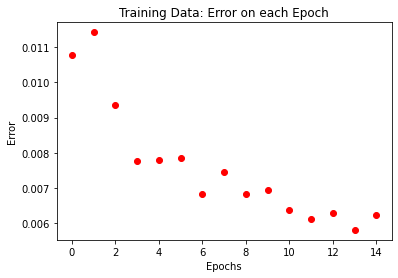

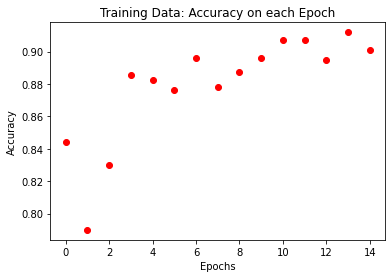

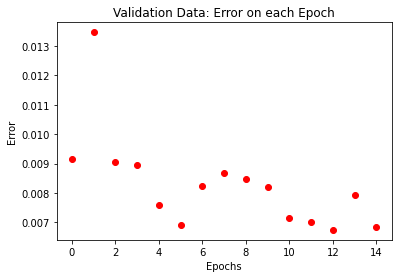

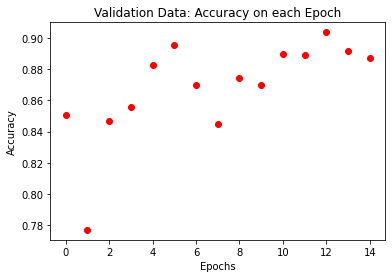

In [85]:
plt.figure()
plt.plot(train_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Data: Error on each Epoch')

plt.figure()
plt.plot(train_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Data: Accuracy on each Epoch')

plt.figure()
plt.plot(val_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Validation Data: Error on each Epoch')

plt.figure()
plt.plot(val_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Data: Accuracy on each Epoch')

In [86]:
print('Final Training Confusion Matrix')
print(confusion_matrices_train[-1])
print('Final Validation Confusion Matrix')
print(confusion_matrices_val[-1])

Final Training Confusion Matrix
[[12989  1414]
 [ 2671 14620]]
Final Validation Confusion Matrix
[[13510  1449]
 [ 2765 15066]]


In [87]:
correct = 0
total = 0
image11=0
image12=0
image13=0
image14=0
image21=0
image22=0
image23=0
image24=0
predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

with torch.no_grad():
    first_l1=True
    first_l2=True
    first_l3=True
    first_l4=True
    highest_prob=0
    lowest_prob=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
          if labels[i].item()==0:
            if predicted[i]==labels[i]:
              if first_l1:
                image11=images[i]
                image12=images[i]
                first_l1=False
              if torch.max(outputs[i].data)>highest_prob:
                image12=image11
                image11=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l2:
                imagel3=images[i]
                image14=images[i]
                first_l2=False
              if torch.min(outputs[i].data)<lowest_prob:
                image14=image13
                image13=images[i]
                lowest_prob=torch.min(outputs[i].data)
          elif labels[i].item()==1:
            if predicted[i]==labels[i]:
              if first_l3:
                image22=images[i]
                image21=images[i]
                first_l3=False
              if torch.max(outputs[i].data)>highest_prob:
                image22=image21
                image21=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l4:
                image23=images[i]
                image24=images[i]
                first_l4=False
              if torch.min(outputs[i].data)<lowest_prob:
                image24=image23
                image23=images[i]
                lowest_prob=torch.min(outputs[i].data)

        predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
        labelsList = torch.cat([labelsList,labels.view(-1).cpu()])

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
print('Conusion Matrix',cf_mat)

cf=cf_mat
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy of the network on test images: 95 %
Conusion Matrix [[553  11]
 [ 39 617]]
Accuracy: 0.9590163934426229
F1 Score: 0.9567474048442905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


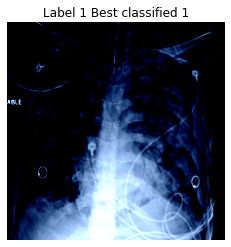

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


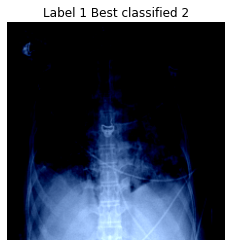

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


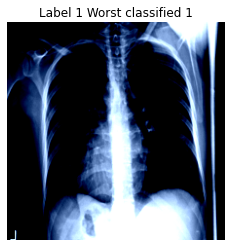

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


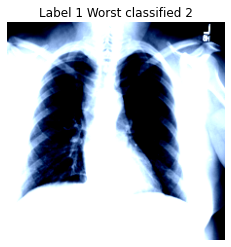

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


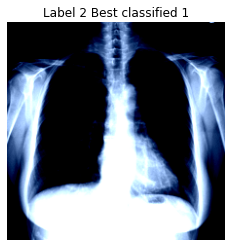

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


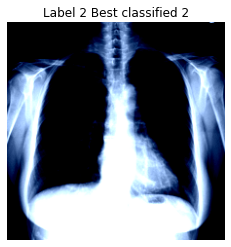

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


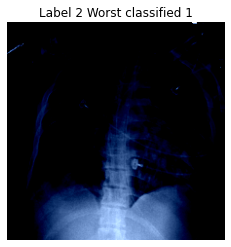

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


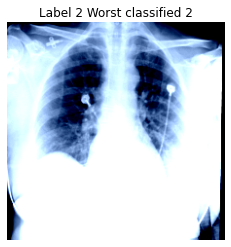

In [88]:
l=torchvision.utils.make_grid(image11)
imshow(l,'Label 1 Best classified 1')
l2=torchvision.utils.make_grid(image12)
imshow(l2,'Label 1 Best classified 2')

l3=torchvision.utils.make_grid(image13)
imshow(l3,'Label 1 Worst classified 1')
l4=torchvision.utils.make_grid(image14)
imshow(l4,'Label 1 Worst classified 2')

l=torchvision.utils.make_grid(image21)
imshow(l,'Label 2 Best classified 1')
l2=torchvision.utils.make_grid(image22)
imshow(l2,'Label 2 Best classified 2')

l3=torchvision.utils.make_grid(image23)
imshow(l3,'Label 2 Worst classified 1')
l4=torchvision.utils.make_grid(image24)
imshow(l4,'Label 2 Worst classified 2')

#RESNET 
Unfreeze Convolution Layer

In [89]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)

res18.fc = nn.Sequential(nn.Linear(512, 240),nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear(240, 2))
print(res18)

child_counter = 0
for child in res18.children():
  if child_counter!=0:
    for param in child.parameters():
      param.require_grad = False 
  child_counter += 1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [90]:
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

res18.to(device)
res18.train()

predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

train_losses,train_accuracies,val_losses,val_accuracies=[],[],[],[]
confusion_matrices_val,confusion_matrices_train=[],[]
best_accuracy=0
for epoch in range(Epochs):  # loop over the dataset multiple times
  print('Epoch',epoch)
  for mode in ['train', 'validation']:
    running_loss = 0.0
    correct_predictions = 0
    if mode=='train':
      pbar = enumerate(trainloader)
    else:
      pbar = enumerate(valloader)
    running_loss = 0.0
    correct_predictions = 0

    for i, data in pbar:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = res18(inputs)            #----> forward pass
      _, predicted = torch.max(outputs, 1)
      loss = criterion(outputs, labels)   #----> compute loss
      if mode=='train':
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      running_loss += loss.item()
      correct_predictions += torch.sum(predicted == labels.data)

      predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
      labelsList = torch.cat([labelsList,labels.view(-1).cpu()])
            
    epoch_accuracy = correct_predictions.double() /1090
    epoch_loss = running_loss /1090
    print('Mode:',mode)
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                      epoch_loss, epoch_accuracy))
        
    cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
    # print('Confusion Matrix',cf_mat)
        
    if mode == 'validation':
      if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
      val_accuracies.append(epoch_accuracy)
      val_losses.append(epoch_loss)
      confusion_matrices_val.append(cf_mat)
    elif mode == 'train':
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_accuracy)
      confusion_matrices_train.append(cf_mat)
      
  torch.save(res18.state_dict(), 'res18_conv_unfreeze.pth')
print('Finished Training')

Epoch 0
Mode: train
Loss: 0.0164 Acc: 0.6119
Mode: validation
Loss: 0.0173 Acc: 0.5615
Epoch 1
Mode: train
Loss: 0.0133 Acc: 0.7743
Mode: validation
Loss: 0.0141 Acc: 0.7422
Epoch 2
Mode: train
Loss: 0.0109 Acc: 0.8257
Mode: validation
Loss: 0.0130 Acc: 0.7761
Epoch 3
Mode: train
Loss: 0.0098 Acc: 0.8422
Mode: validation
Loss: 0.0114 Acc: 0.8092
Epoch 4
Mode: train
Loss: 0.0088 Acc: 0.8560
Mode: validation
Loss: 0.0094 Acc: 0.8468
Epoch 5
Mode: train
Loss: 0.0078 Acc: 0.8725
Mode: validation
Loss: 0.0100 Acc: 0.8413
Epoch 6
Mode: train
Loss: 0.0080 Acc: 0.8789
Mode: validation
Loss: 0.0100 Acc: 0.8431
Epoch 7
Mode: train
Loss: 0.0073 Acc: 0.8817
Mode: validation
Loss: 0.0098 Acc: 0.8468
Epoch 8
Mode: train
Loss: 0.0071 Acc: 0.8853
Mode: validation
Loss: 0.0110 Acc: 0.8284
Epoch 9
Mode: train
Loss: 0.0071 Acc: 0.8853
Mode: validation
Loss: 0.0096 Acc: 0.8468
Epoch 10
Mode: train
Loss: 0.0073 Acc: 0.8835
Mode: validation
Loss: 0.0095 Acc: 0.8633
Epoch 11
Mode: train
Loss: 0.0071 Acc: 0.8

Text(0.5, 1.0, 'Validation Data: Accuracy on each Epoch')

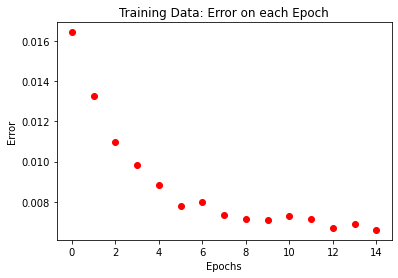

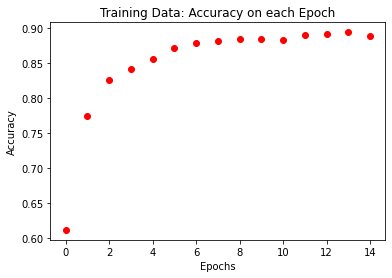

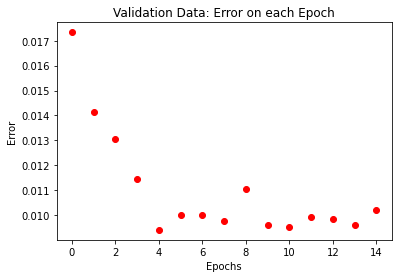

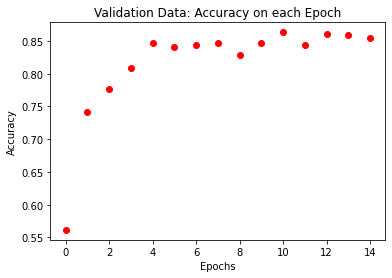

In [91]:
plt.figure()
plt.plot(train_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Data: Error on each Epoch')

plt.figure()
plt.plot(train_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Data: Accuracy on each Epoch')

plt.figure()
plt.plot(val_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Validation Data: Error on each Epoch')

plt.figure()
plt.plot(val_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Data: Accuracy on each Epoch')

In [92]:
print('Final Training Confusion Matrix')
print(confusion_matrices_train[-1])
print('Final Validation Confusion Matrix')
print(confusion_matrices_val[-1])

Final Training Confusion Matrix
[[11795  1524]
 [ 3865 14510]]
Final Validation Confusion Matrix
[[12276  1554]
 [ 3999 14961]]


In [93]:
correct = 0
total = 0
image11=0
image12=0
image13=0
image14=0
image21=0
image22=0
image23=0
image24=0
predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

with torch.no_grad():
    first_l1=True
    first_l2=True
    first_l3=True
    first_l4=True
    highest_prob=0
    lowest_prob=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
          if labels[i].item()==0:
            if predicted[i]==labels[i]:
              if first_l1:
                image11=images[i]
                image12=images[i]
                first_l1=False
              if torch.max(outputs[i].data)>highest_prob:
                image12=image11
                image11=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l2:
                imagel3=images[i]
                image14=images[i]
                first_l2=False
              if torch.min(outputs[i].data)<lowest_prob:
                image14=image13
                image13=images[i]
                lowest_prob=torch.min(outputs[i].data)
          elif labels[i].item()==1:
            if predicted[i]==labels[i]:
              if first_l3:
                image22=images[i]
                image21=images[i]
                first_l3=False
              if torch.max(outputs[i].data)>highest_prob:
                image22=image21
                image21=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l4:
                image23=images[i]
                image24=images[i]
                first_l4=False
              if torch.min(outputs[i].data)<lowest_prob:
                image24=image23
                image23=images[i]
                lowest_prob=torch.min(outputs[i].data)

        predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
        labelsList = torch.cat([labelsList,labels.view(-1).cpu()])

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
print('Conusion Matrix',cf_mat)

cf=cf_mat
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy of the network on test images: 94 %
Conusion Matrix [[533  13]
 [ 59 615]]
Accuracy: 0.940983606557377
F1 Score: 0.9367311072056239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


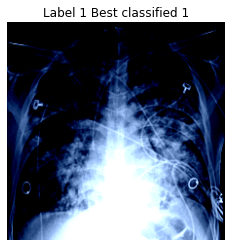

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


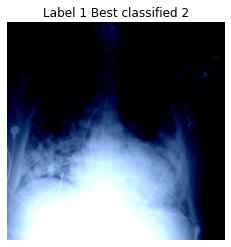

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


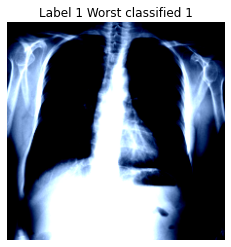

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


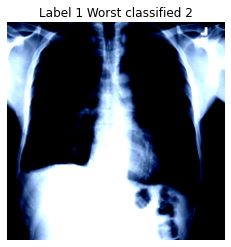

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


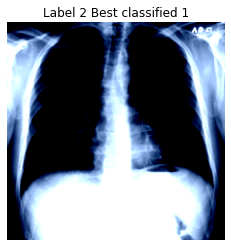

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


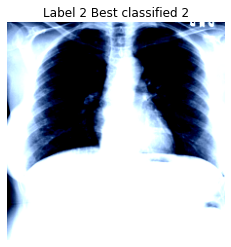

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


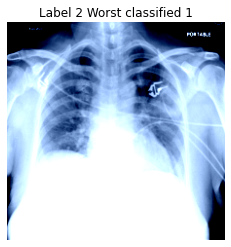

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


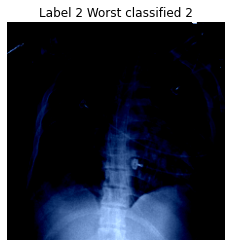

In [94]:
l=torchvision.utils.make_grid(image11)
imshow(l,'Label 1 Best classified 1')
l2=torchvision.utils.make_grid(image12)
imshow(l2,'Label 1 Best classified 2')

l3=torchvision.utils.make_grid(image13)
imshow(l3,'Label 1 Worst classified 1')
l4=torchvision.utils.make_grid(image14)
imshow(l4,'Label 1 Worst classified 2')

l=torchvision.utils.make_grid(image21)
imshow(l,'Label 2 Best classified 1')
l2=torchvision.utils.make_grid(image22)
imshow(l2,'Label 2 Best classified 2')

l3=torchvision.utils.make_grid(image23)
imshow(l3,'Label 2 Worst classified 1')
l4=torchvision.utils.make_grid(image24)
imshow(l4,'Label 2 Worst classified 2')

All Layers Unfreeze

In [95]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)

res18.fc = nn.Sequential(nn.Linear(512, 240),nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear(240, 2))
print(res18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [96]:
Epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

res18.to(device)
res18.train()

predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

train_losses,train_accuracies,val_losses,val_accuracies=[],[],[],[]
confusion_matrices_val,confusion_matrices_train=[],[]
best_accuracy=0
for epoch in range(Epochs):  # loop over the dataset multiple times
  print('Epoch',epoch)
  for mode in ['train', 'validation']:
    running_loss = 0.0
    correct_predictions = 0
    if mode=='train':
      pbar = enumerate(trainloader)
    else:
      pbar = enumerate(valloader)
    running_loss = 0.0
    correct_predictions = 0

    for i, data in pbar:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = res18(inputs)            #----> forward pass
      _, predicted = torch.max(outputs, 1)
      loss = criterion(outputs, labels)   #----> compute loss
      if mode=='train':
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      running_loss += loss.item()
      correct_predictions += torch.sum(predicted == labels.data)

      predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
      labelsList = torch.cat([labelsList,labels.view(-1).cpu()])
            
    epoch_accuracy = correct_predictions.double() /1090
    epoch_loss = running_loss /1090
    print('Mode:',mode)
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                      epoch_loss, epoch_accuracy))
        
    cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
    # print('Confusion Matrix',cf_mat)
        
    if mode == 'validation':
      if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
      val_accuracies.append(epoch_accuracy)
      val_losses.append(epoch_loss)
      confusion_matrices_val.append(cf_mat)
    elif mode == 'train':
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_accuracy)
      confusion_matrices_train.append(cf_mat)
      
  torch.save(res18.state_dict(), 'res18_entire.pth')
print('Finished Training')

Epoch 0
Mode: train
Loss: 0.0161 Acc: 0.6358
Mode: validation
Loss: 0.0151 Acc: 0.6954
Epoch 1
Mode: train
Loss: 0.0131 Acc: 0.7716
Mode: validation
Loss: 0.0129 Acc: 0.7661
Epoch 2
Mode: train
Loss: 0.0104 Acc: 0.8266
Mode: validation
Loss: 0.0128 Acc: 0.7853
Epoch 3
Mode: train
Loss: 0.0096 Acc: 0.8339
Mode: validation
Loss: 0.0109 Acc: 0.8138
Epoch 4
Mode: train
Loss: 0.0084 Acc: 0.8560
Mode: validation
Loss: 0.0111 Acc: 0.8211
Epoch 5
Mode: train
Loss: 0.0086 Acc: 0.8578
Mode: validation
Loss: 0.0109 Acc: 0.8239
Epoch 6
Mode: train
Loss: 0.0084 Acc: 0.8560
Mode: validation
Loss: 0.0100 Acc: 0.8413
Epoch 7
Mode: train
Loss: 0.0078 Acc: 0.8761
Mode: validation
Loss: 0.0099 Acc: 0.8422
Epoch 8
Mode: train
Loss: 0.0076 Acc: 0.8872
Mode: validation
Loss: 0.0091 Acc: 0.8596
Epoch 9
Mode: train
Loss: 0.0070 Acc: 0.8817
Mode: validation
Loss: 0.0093 Acc: 0.8440
Epoch 10
Mode: train
Loss: 0.0072 Acc: 0.8927
Mode: validation
Loss: 0.0098 Acc: 0.8413
Epoch 11
Mode: train
Loss: 0.0069 Acc: 0.8

Text(0.5, 1.0, 'Validation Data: Accuracy on each Epoch')

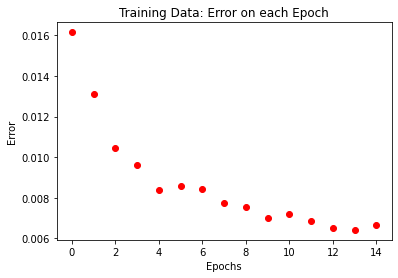

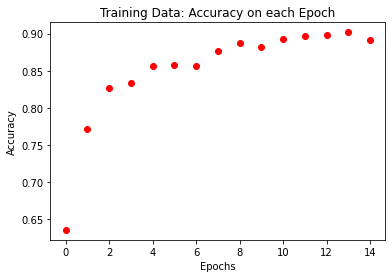

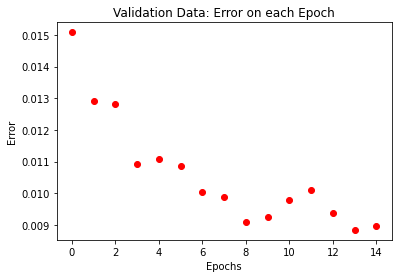

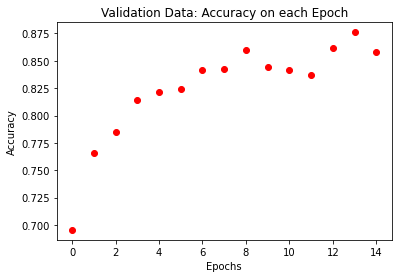

In [97]:
plt.figure()
plt.plot(train_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Data: Error on each Epoch')

plt.figure()
plt.plot(train_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Data: Accuracy on each Epoch')

plt.figure()
plt.plot(val_losses,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Validation Data: Error on each Epoch')

plt.figure()
plt.plot(val_accuracies,'o', color="r")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Data: Accuracy on each Epoch')

In [98]:
print('Final Training Confusion Matrix')
print(confusion_matrices_train[-1])
print('Final Validation Confusion Matrix')
print(confusion_matrices_val[-1])

Final Training Confusion Matrix
[[12063  1640]
 [ 3597 14394]]
Final Validation Confusion Matrix
[[12552  1675]
 [ 3723 14840]]


In [99]:
correct = 0
total = 0
image11=0
image12=0
image13=0
image14=0
image21=0
image22=0
image23=0
image24=0
predictedList=torch.zeros( 0, dtype=torch.long)
labelsList=torch.zeros( 0, dtype=torch.long)

with torch.no_grad():
    first_l1=True
    first_l2=True
    first_l3=True
    first_l4=True
    highest_prob=0
    lowest_prob=0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
          if labels[i].item()==0:
            if predicted[i]==labels[i]:
              if first_l1:
                image11=images[i]
                image12=images[i]
                first_l1=False
              if torch.max(outputs[i].data)>highest_prob:
                image12=image11
                image11=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l2:
                imagel3=images[i]
                image14=images[i]
                first_l2=False
              if torch.min(outputs[i].data)<lowest_prob:
                image14=image13
                image13=images[i]
                lowest_prob=torch.min(outputs[i].data)
          elif labels[i].item()==1:
            if predicted[i]==labels[i]:
              if first_l3:
                image22=images[i]
                image21=images[i]
                first_l3=False
              if torch.max(outputs[i].data)>highest_prob:
                image22=image21
                image21=images[i]
                highest_prob=torch.max(outputs[i].data)
            else:
              if first_l4:
                image23=images[i]
                image24=images[i]
                first_l4=False
              if torch.min(outputs[i].data)<lowest_prob:
                image24=image23
                image23=images[i]
                lowest_prob=torch.min(outputs[i].data)

        predictedList =  torch.cat([predictedList,predicted.view(-1).cpu()])
        labelsList = torch.cat([labelsList,labels.view(-1).cpu()])

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))
cf_mat=confusion_matrix(predictedList.numpy(), labelsList.numpy())
print('Conusion Matrix',cf_mat)

cf=cf_mat
accuracy= (cf[0][0]+cf[1][1] )/ (cf[0][0]+cf[0][1]+cf[1][0]+cf[1][1])
precision= cf[0][0] / (cf[0][0]+cf[0][1])
recall = cf[0][0] / (cf[0][0]+cf[1][0])
f1= 2* (precision * recall) / (precision + recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Accuracy of the network on test images: 93 %
Conusion Matrix [[528  20]
 [ 64 608]]
Accuracy: 0.9311475409836065
F1 Score: 0.9263157894736843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


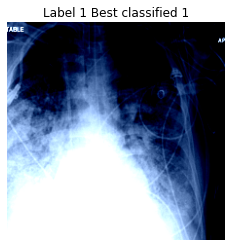

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


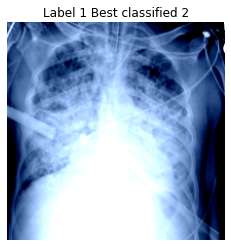

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


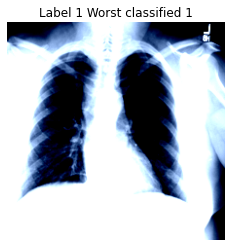

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


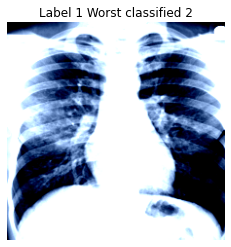

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


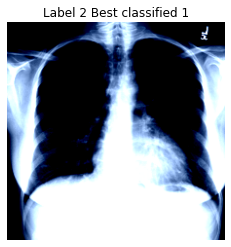

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


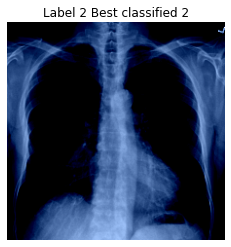

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


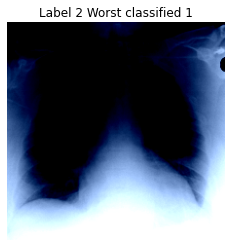

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


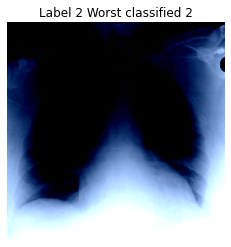

In [100]:
l=torchvision.utils.make_grid(image11)
imshow(l,'Label 1 Best classified 1')
l2=torchvision.utils.make_grid(image12)
imshow(l2,'Label 1 Best classified 2')

l3=torchvision.utils.make_grid(image13)
imshow(l3,'Label 1 Worst classified 1')
l4=torchvision.utils.make_grid(image14)
imshow(l4,'Label 1 Worst classified 2')

l=torchvision.utils.make_grid(image21)
imshow(l,'Label 2 Best classified 1')
l2=torchvision.utils.make_grid(image22)
imshow(l2,'Label 2 Best classified 2')

l3=torchvision.utils.make_grid(image23)
imshow(l3,'Label 2 Worst classified 1')
l4=torchvision.utils.make_grid(image24)
imshow(l4,'Label 2 Worst classified 2')